In [60]:
import numpy as np
import cv2

img = cv2.imread('img_3.png', cv2.IMREAD_GRAYSCALE)

def split_vertical_lines(img: np.ndarray):
    """
    Given a 2D grayscale (or binary) image `img` of shape (H, W),
    returns two uint8 images (H, W):
      - vertical: all pixels that belong to 1‑pixel‑wide vertical runs
      - rest:      the original image with those vertical pixels zeroed out

    A pixel at (y,x) is classified as "vertical" if:
       img[y,x] != 0
       AND img[y, x-1] == 0  (or x == 0)
       AND img[y, x+1] == 0  (or x == W-1)

    This picks out any vertical stroke of width exactly one.
    """
    # flatten shape
    if img.ndim != 2:
        raise ValueError("Input must be a 2D array")
    H, W = img.shape

    # foreground mask (non-zero)
    fg = img != 0

    # shift provided left/right (out‑of‑bounds treated as False)
    left  = np.zeros_like(fg)
    right = np.zeros_like(fg)
    left[:, 1:]  = fg[:, :-1]
    right[:, :-1] = fg[:, 1:]

    # a pixel is a 1‑px vertical line if it's on and both neighbors are off
    vertical_mask = fg & ~left & ~right

    # build output images
    vertical = np.zeros_like(img, dtype=np.uint8)
    rest     = img.copy().astype(np.uint8)

    vertical[vertical_mask] = img[vertical_mask]
    rest[vertical_mask]     = 0

    return vertical, rest


def segment_assault_by_yranges(frame: np.ndarray):
    """
    Purely spatial segmentation of a grayscale Assault frame into five provided:
      1) mothership band
      2) enemies band
      3) bullets band (same as playfield)
      4) all UI (top + bottom)
      5) lives UI only (bottom UI, left slice)

    Input:
      frame: H×W or H×W×1 uint8 array
    Returns:
      moth, enemies, bullets, ui_all, ui_lives
      each an H×W uint8 mask (0 or original pixel)
    """
    # flatten to H×W
    if frame.ndim == 3 and frame.shape[2] == 1:
        img = frame[:, :, 0]
    else:
        img = frame
    H, W = img.shape

    # define breakpoints (fractions of H)
    top_ui_frac     = 0.08   # top 8% = scoreboard
    moth_frac       = 0.15
    enemy_frac      = 0.64
    # bottom UI fraction ~8%
    bottom_ui_frac  = 0.12
    bottom_ui_bar_frac = 0.04

    # compute pixel rows
    y0_top_ui    = 0
    y1_top_ui    = int(H * top_ui_frac)
    y0_moth      = y1_top_ui
    y1_moth      = y0_moth + int(H * moth_frac)
    y0_enemy     = y1_moth
    y1_enemy     = y0_enemy + int(H * enemy_frac)
    y0_player    = y1_enemy
    y1_player    = H - int(H * bottom_ui_frac)
    y0_bottom_ui = y1_player
    y1_bottom_ui = H

    # 1) Mothership mask: keep only rows [y0_moth:y1_moth]
    moth = np.zeros_like(img)
    moth[y0_moth:y1_moth, :] = img[y0_moth:y1_moth, :]

    # 2) Enemies mask: rows [y0_enemy:y1_enemy]
    enemies = np.zeros_like(img)
    enemies[y0_enemy:y1_enemy, :] = img[y0_enemy:y1_enemy, :]

    # 3) Bullets mask: rows [y0_bullets:y1_bullets]
    #    (this is just the playfield excluding moth/enemy bands)
    player = np.zeros_like(img)
    player[y0_player:y1_player, :] = img[y0_player:y1_player, :]

    # 4) All UI: top UI + bottom UI
    ui_all = np.zeros_like(img)
    ui_all[y0_top_ui:y1_top_ui, :]       = img[y0_top_ui:y1_top_ui, :]
    ui_all[y0_bottom_ui:y1_bottom_ui, :] = img[y0_bottom_ui:y1_bottom_ui, :]

    # 5) Lives-only UI: bottom UI, leftmost 25% of width
    lives_w = int(W * 0.5)
    ui_lives = np.zeros_like(img)
    ui_lives[y0_bottom_ui + int(H * bottom_ui_bar_frac):y1_bottom_ui, 0:lives_w] = img[y0_bottom_ui + int(H * bottom_ui_bar_frac):y1_bottom_ui, 0:lives_w]

    lives_w = int(W * 0.5)
    ui_cannon = np.zeros_like(img)
    ui_cannon[y0_bottom_ui + int(H * bottom_ui_bar_frac):y1_bottom_ui, lives_w:W] = img[y0_bottom_ui + int(H * bottom_ui_bar_frac):y1_bottom_ui, lives_w:W]

    return moth, *split_vertical_lines(enemies), player, ui_all, ui_lives, ui_cannon

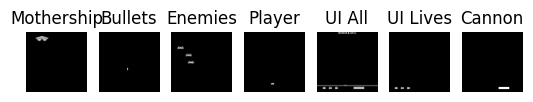

In [61]:
import matplotlib.pyplot as plt
titles = ['Mothership','Bullets', 'Enemies','Player','UI All','UI Lives', 'Cannon']
imgs   = segment_assault_by_yranges(img)
for i, im in enumerate(imgs):
    plt.subplot(1,7,i+1)
    plt.imshow(im, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

In [62]:

def weighted_centroid(img: np.ndarray):
    """
    Compute the intensity-weighted centroid of a 2D grayscale image.

    Args:
      img: 2D numpy array of shape (H, W), dtype float or uint8.

    Returns:
      (x_centroid, y_centroid): floats giving the weighted average
        of the column and row indices, respectively.
    """
    # ensure float
    I = img.astype(np.float64)

    # coordinates
    H, W = I.shape
    ys = np.arange(H)[:, None]  # shape (H,1)
    xs = np.arange(W)[None, :]  # shape (1,W)

    total_intensity = I.sum()
    if total_intensity == 0:
        # avoid division by zero; return center of image
        return (W - 1) / 2.0, (H - 1) / 2.0

    x_center = (I * xs).sum() / total_intensity
    y_center = (I * ys).sum() / total_intensity

    return x_center, y_center

print(np.max(imgs[0]))
print(weighted_centroid(imgs[2]))

147
(np.float64(21.07392723880597), np.float64(32.54500932835821))
